In [2]:
from pathlib import Path
import json
from dataclasses import dataclass
from PIL import Image


@dataclass
class Frame:
    image: Image
    matrix: list[list[float]]


class Scene:
    def __init__(self, path: Path):
        with open(path / "transforms.json", "r") as f:
            transforms = json.load(f)

        self.frames = []
        for frame in transforms["frames"]:
            image_path = path / frame["file_path"]
            if image_path.exists():
                self.frames.append(
                    Frame(Image.open(image_path), frame["transform_matrix"])
                )


scene = Scene(Path("assets/fox"))

In [3]:
import torch as tch
from torch import nn, functional as F
import numpy as np

In [4]:
dev = tch.device("cuda:0")

In [5]:
from typing import Callable


def raymarch(
    func: Callable[[tch.Tensor], tch.Tensor],
    init_rays: tch.Tensor,
    step_size: float,
    max_distance: float,
) -> tch.Tensor:
    """
    Args:
    + func(rays of shape (B, 6)) -> image of (B, 4)
    + init_rays of shape: (B, 6) where last dim contains: [px, py, pz, dx, dy, dz]
    + ...

    Returns image of shape (B, 4) where last dim contains: [r, g, b, opacity]
    """

    image_accum = tch.zeros((init_rays.shape[0], 4), device=init_rays.device)
    distance = 0.0
    while distance <= max_distance:
        init_pos, dir = init_rays[:, :3], init_rays[:, 3:]
        pos = init_pos + dir * distance
        rays = tch.cat([pos, dir], -1)

        image = func(rays)
        color, opacity = image[:, :3], image[:, 3:]
        old_color, old_opacity = image_accum[:, :3], image_accum[:, 3:]
        factor = (1.0 - old_opacity) * opacity
        new_color = old_color + factor * color
        new_opacity = old_opacity + factor
        image_accum = tch.cat([new_color, new_opacity], dim=-1)

        distance += step_size

    return image_accum


In [6]:
from nerfpg import grid


def pad_right(t: tch.Tensor, value: float, count: int = 1) -> tch.Tensor:
    return tch.cat(
        [t, tch.tensor(value, device=t.device).broadcast_to((*t.shape[:-1], count))],
        dim=-1,
    )


def rays_grid(
    transform: list[list[float]],
    angles: tuple[float, float],
    shape: tuple[int, int],
    dev: tch.device,
) -> tch.Tensor:
    """
    Returned tensor shape: (shape[0], shape[1], 6)
    """
    matrix = tch.tensor(transform, device=dev).transpose(0, 1)

    dxy = (2.0 * grid(shape, dev) - 1.0)
    dxy = dxy * (tch.tensor(angles, device=dev) / 2.0).tan()

    dir = pad_right(dxy, 1.0)
    dir = dir / dir.pow(2).sum(dim=-1, keepdim=True)  # normalize direction vectors
    dir = tch.matmul(pad_right(dir, 0.0), matrix)[:, :, :3]

    pos = matrix[3, :3].reshape((1, 1, 3)).broadcast_to((*shape, 3))
    return tch.cat([pos, dir], dim=-1)


res = (256, 256)
distance = 4.0
transform = [
    [1.0, 0.0, 0.0, 0.0],
    [0.0, 1.0, 0.0, 0.0],
    [0.0, 0.0, 1.0, -distance],
    [0.0, 0.0, 0.0, 1.0],
]
rays = rays_grid(transform, (np.pi / 2, np.pi / 2), res, dev).flatten(0, 1)
rays

tensor([[ 0.0000,  0.0000, -4.0000, -0.3333, -0.3333,  0.3333],
        [ 0.0000,  0.0000, -4.0000, -0.3351, -0.3325,  0.3351],
        [ 0.0000,  0.0000, -4.0000, -0.3368, -0.3315,  0.3368],
        ...,
        [ 0.0000,  0.0000, -4.0000,  0.3368,  0.3315,  0.3368],
        [ 0.0000,  0.0000, -4.0000,  0.3351,  0.3325,  0.3351],
        [ 0.0000,  0.0000, -4.0000,  0.3333,  0.3333,  0.3333]],
       device='cuda:0')

In [7]:
def gaussian_fog(rays: tch.Tensor) -> tch.Tensor:
    pos = rays[:, :3]
    density = pos.pow(2).sum(dim=-1, keepdim=True).exp().reciprocal()
    color = tch.tensor(1.0, device=rays.device).broadcast_to((density.shape[0], 3))
    return tch.cat([color, density], dim=-1)


gaussian_fog(rays)

tensor([[1.0000e+00, 1.0000e+00, 1.0000e+00, 1.1254e-07],
        [1.0000e+00, 1.0000e+00, 1.0000e+00, 1.1254e-07],
        [1.0000e+00, 1.0000e+00, 1.0000e+00, 1.1254e-07],
        ...,
        [1.0000e+00, 1.0000e+00, 1.0000e+00, 1.1254e-07],
        [1.0000e+00, 1.0000e+00, 1.0000e+00, 1.1254e-07],
        [1.0000e+00, 1.0000e+00, 1.0000e+00, 1.1254e-07]], device='cuda:0')

In [8]:
image = raymarch(gaussian_fog, rays, 0.01, 2.0 * distance)
image

tensor([[0.0071, 0.0071, 0.0071, 0.0071],
        [0.0073, 0.0073, 0.0073, 0.0073],
        [0.0075, 0.0075, 0.0075, 0.0075],
        ...,
        [0.0075, 0.0075, 0.0075, 0.0075],
        [0.0073, 0.0073, 0.0073, 0.0073],
        [0.0071, 0.0071, 0.0071, 0.0071]], device='cuda:0')

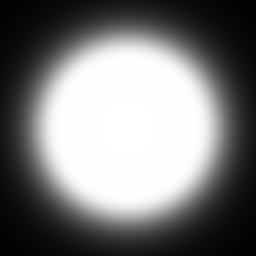

In [9]:
from nerfpg import tensor_to_image

tensor_to_image(image[:, :3].reshape(*res, 3).permute(2, 0, 1))